# example of earthquake time-forecasting CNN
Ong, Giani, Nielsen

**mount Google Drive as a disk to access files and data**






In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cd  "/content/drive/MyDrive/DISS_FOLDER/Veda_Data"

/content/drive/MyDrive/DISS_FOLDER/Veda_Data


In [3]:
import pickle
import numpy as np

**set choice for input files (determines the type of normalisation)**

In [4]:
choice = 'new2' # old=norm on all 3 components together. new2=no norm. new=norm on individual componenets, 


**set name of output model weights**

In [5]:
# name of model weights file with version number of the training
tnum=2
WeightsFile='./model_'+str(tnum)+'.h5'
print('weights for the pending training will be saved in:',WeightsFile)

weights for the pending training will be saved in: ./model_2.h5


**read input files**

In [6]:
normnoise = pickle.load( open( "./Data/normnoise_"+choice+".p", "rb" ) )
normpre = pickle.load( open( "./Data/normpre_"+choice+".p", "rb" ) )
testlist = pickle.load( open( "./Data/testlist.p", "rb" ) )
trainlist = pickle.load( open( "./Data/trainlist.p", "rb" ) )

In [7]:
x_train = [normpre[i] for i in trainlist]
x_test = [normpre[i] for i in testlist]
x_noise_train = [normnoise[i] for i in trainlist]
x_noise_test = [normnoise[i] for i in testlist]

window_length=16384

#Make data into a format such that it can be concatenated
x_train2 = np.reshape(x_train, (len(x_train)*len(x_train[0]), window_length, 3))
x_test2 = np.reshape(x_test, (len(x_test)*len(x_test[0]), window_length, 3))
x_noise_train2 = np.expand_dims(x_noise_train, axis=-1)
x_noise_test2 = np.expand_dims(x_noise_test, axis=-1)
x_noise_train2 = np.reshape(x_noise_train2, (len(x_noise_train)*len(x_noise_train[0]), window_length, 3))
x_noise_test2 = np.reshape(x_noise_test2, (len(x_noise_test)*len(x_noise_test[0]), window_length, 3))

# Generate ground truth (ones = 'precursor' class, zeros = 'noise' class)
y_train2 = np.ones(len(x_train2))
y_test2 =np.ones(len(x_test2))
y_noise_train2 = np.zeros(len(x_noise_train2))
y_noise_test2 = np.zeros(len(x_noise_test2))
y_train2  = y_train2.tolist()
y_test2 = y_test2.tolist()
y_noise_train2 = y_noise_train2.tolist()
y_noise_test2 = y_noise_test2.tolist()

#Concatenate noise and precursor datasets 
x_train = np.append(x_train2,x_noise_train2, axis=0)
x_test = np.append(x_test2,x_noise_test2, axis=0)
y_train = np.append(y_train2,y_noise_train2, axis=0)
y_test = np.append(y_test2,y_noise_test2, axis=0)

**buid the CNN footprint**

In [8]:

!pip install pip install np_utils

#from keras.utils import to_categorical
from keras.utils.np_utils import to_categorical
y_train= to_categorical(y_train, num_classes=2)
y_test= to_categorical(y_test, num_classes=2)

import tensorflow as tf 
import numpy as np
import time
import os
from keras.models import Model
from keras.layers import Conv1D, BatchNormalization, Add, MaxPooling1D, Dropout, Dense, Flatten, CuDNNLSTM, ZeroPadding1D
from keras.layers import Activation, Input, concatenate, GaussianNoise, GlobalMaxPooling1D, GlobalAveragePooling1D, Softmax, Permute, Multiply, Masking
#from keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.optimizers import Adam,RMSprop, SGD
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras
from keras.regularizers import *  

def encoder(input_shape, nb_classes):
    
    input_layer= Input(input_shape)
    random = Conv1D(3, 3, padding='same', kernel_initializer='random_normal')(input_layer) #NEED TO CHANGE 3->6??

    X = Add()([input_layer, random])

    conv3 = Conv1D(filters=32, kernel_size=7,padding='same', strides=1, kernel_initializer='random_normal')(X)
    conv3 = Conv1D(filters=32, kernel_size=7,padding='same', strides=1, kernel_initializer='random_normal')(conv3)
    conv3 = MaxPooling1D(3, strides=1)(conv3)
    conv3 = BatchNormalization()(conv3)
    conv3 = Activation('relu')(conv3)

    conv4 = Conv1D(64, kernel_size=7,padding='same', strides=1, kernel_initializer='random_normal')(conv3)
    conv4 = Conv1D(64, kernel_size=7,padding='same', strides=1, kernel_initializer='random_normal')(conv4)        
    conv4 = MaxPooling1D(3, strides=2)(conv4)
    conv4 = BatchNormalization()(conv4)
    conv4 = Activation('relu')(conv4)

    conv5 = Conv1D(filters=64, kernel_size=5, padding='same', dilation_rate=2, kernel_initializer='random_normal')(conv4)
    conv5 = MaxPooling1D(3, strides=1)(conv5)
    conv5 = BatchNormalization()(conv5)
    conv5 = Activation('relu')(conv5)
        
    conv3 = Conv1D(filters=128, kernel_size=5,padding='same', dilation_rate=4 , kernel_initializer='random_normal')(conv5)
    conv3 = MaxPooling1D(3, strides=1)(conv3)
    conv3 = BatchNormalization()(conv3)
    conv3 = Activation('relu')(conv3)

    conv3 = Conv1D(filters=128, kernel_size=5,padding='same', dilation_rate=8 , kernel_initializer='random_normal')(conv3)
    conv3 = MaxPooling1D(3, strides=1)(conv3)
    conv3 = BatchNormalization()(conv3)
    conv3 = Activation('relu')(conv3)

    conv4 = Conv1D(256, kernel_size=3,padding='same',  dilation_rate=16 , kernel_initializer='random_normal')(conv3)
    conv4 = MaxPooling1D(3, strides=1)(conv4)
    conv4 = BatchNormalization()(conv4)
    conv4 = Activation('relu')(conv4)

    conv5 = Conv1D(filters=256, kernel_size=3, padding='same', dilation_rate=32, kernel_initializer='random_normal')(conv4)
    conv5 = MaxPooling1D(3, strides=1)(conv5)
    conv5 = BatchNormalization()(conv5)
    conv5 = Activation('relu')(conv5)
    conv5 = Dropout(0.02)(conv5)
  
    Y = GlobalAveragePooling1D()(conv5)
    Y = Dense(256, activation='relu', kernel_initializer='random_normal')(Y)
    Y = Dropout(0.02)(Y)

  
    output_layer = Dense(nb_classes, activation='softmax', kernel_initializer='random_normal')(Y)
    
    model = Model(inputs=input_layer, outputs=output_layer)

        
    return model      
    
model=encoder((window_length, 3), 2)   #NEED TO CHANGE 3->6 I THINK
model.compile(loss='binary_crossentropy', optimizer=RMSprop(0.0001), metrics=['accuracy'])
model.summary()  


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 16384, 3)]   0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 16384, 3)     30          ['input_1[0][0]']                
                                                                                                  
 add (Add)                      (None, 16384, 3)     0           ['input_1[0][0]',                
                                                                  'conv1d[0][0]']                 
                                                                                              

In [9]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, Callback
#from matplotlib import pyplot as plt
#from keras.callbacks import TensorBoard
#from keras import backend as K


class My_Callback(Callback):

    def on_epoch_begin(self, epoch, logs={}):
        session = K.get_session()
        self.model.layers[1].kernel.initializer.run(session=session)
        return

    def on_epoch_end(self, epoch, logs={}):
        #layer_index = 0  ## index of the layer you want to change
        # random weights to reset the layer
        #new_weights = np.random.randn(*self.model.layers[layer_index].get_weights().shape)

        #self.model.layers[layer_index].set_weights(new_weights)

        return

callbacks = [
    EarlyStopping(patience=15, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.000001, verbose=1),
    ModelCheckpoint(filepath=WeightsFile, verbose=1, save_best_only=True, monitor='val_accuracy', save_weights_only=False, mode='max'),
    My_Callback()]



**start training the cnn**

In [10]:
#!%%pypy
# This callback reinitialises the weights in the first layer of the neural network (random layer in my report) at the start of each epoch.
class My_Callback(Callback):

    def on_epoch_begin(self, epoch, logs={}):
        # Code change to implement random layer in new version of TensorFlow
        # Get current weights
        weights = self.model.layers[1].get_weights()
        new_weights = []
        # Only the kernel is re-initialized, not the bais. For this reason I copy the old bais in the new weights.
        # I want the new weights to have the same distribution as the old ones. 
        # For this reason, I scale the normal distribution by the stddev and mean of the initializer of the layer.
        # To make sure that the right number of weights are generated, I use the shape of the old weights as a template.
        new_weights.append(self.model.layers[1].kernel_initializer.stddev * np.random.randn(*weights[0].shape) + self.model.layers[1].kernel_initializer.mean)
        
        new_weights.append(weights[1])
        self.model.layers[1].set_weights(new_weights)
        
        return

    def on_epoch_end(self, epoch, logs={}):

        return

# Changed val_acc into val_accuracy in monitor to fir with new version of TensorFlow

# Changed Early Stopping patience from 15 to 30
callbacks = [
    EarlyStopping(patience=30, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1),
    #ModelCheckpoint('weights_nonorm.h5', verbose=1, save_best_only=True, monitor='val_accuracy', save_weights_only=True),
    ModelCheckpoint(WeightsFile, verbose=1, save_best_only=True, monitor='val_accuracy', save_weights_only=True),

My_Callback()]

#model.fit(x_train, y_train, batch_size=16, epochs=100, shuffle=True, callbacks=callbacks,
#                    validation_data=(x_test, y_test))
CNNmodel = model.fit(x_train, y_train, batch_size=32, epochs=100, shuffle=True, callbacks=callbacks, validation_data=(x_test, y_test))

Epoch 1/100
 6/56 [==>...........................] - ETA: 18s - loss: 0.7032 - accuracy: 0.5000

56/56 [==============================] - ETA: 0s - loss: 0.6804 - accuracy: 0.5484
Epoch 1: val_accuracy improved from -inf to 0.61004, saving model to ./model_2.h5
56/56 [==============================] - 29s 410ms/step - loss: 0.6804 - accuracy: 0.5484 - val_loss: 0.6944 - val_accuracy: 0.6100 - lr: 1.0000e-04
Epoch 2/100
56/56 [==============================] - ETA: 0s - loss: 0.6529 - accuracy: 0.6149
Epoch 2: val_accuracy did not improve from 0.61004
56/56 [==============================] - 22s 385ms/step - loss: 0.6529 - accuracy: 0.6149 - val_loss: 0.7104 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 3/100
56/56 [==============================] - ETA: 0s - loss: 0.6156 - accuracy: 0.6470
Epoch 3: val_accuracy did not improve from 0.61004
56/56 [==============================] - 22s 385ms/step - loss: 0.6156 - accuracy: 0.6470 - val_loss: 0.7395 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 4/100
56/56 [==============================] - ETA: 0s - loss: 0.5705 - accuracy: 0.6836
E

**Loading the saved weights and only testing the network (no training) on both train and test datasets:**

In [11]:
model.load_weights(WeightsFile)
Tr = model.evaluate(x_train, y_train, verbose=1)[-1]
Te = model.evaluate(x_test, y_test, verbose=1)[-1]

print('Train Accuracy: ', Tr)
print('Test Accuracy: ', Te)

17/17 [==============================] - 2s 109ms/step - loss: 0.7771 - accuracy: 0.6969
Train Accuracy:  0.7606981992721558
Test Accuracy:  0.6969112157821655


       loss  accuracy  val_loss  val_accuracy       lr
0  0.680421  0.548423  0.694425      0.610039  0.00010
1  0.652948  0.614865  0.710417      0.500000  0.00010
2  0.615636  0.646959  0.739540      0.500000  0.00010
3  0.570470  0.683559  0.748948      0.449807  0.00010
4  0.557076  0.678491  0.844316      0.500000  0.00001


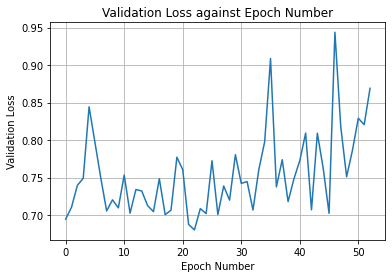

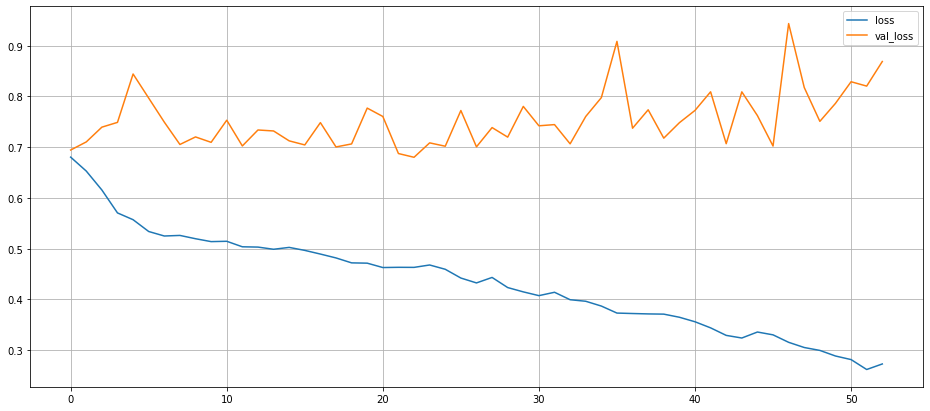

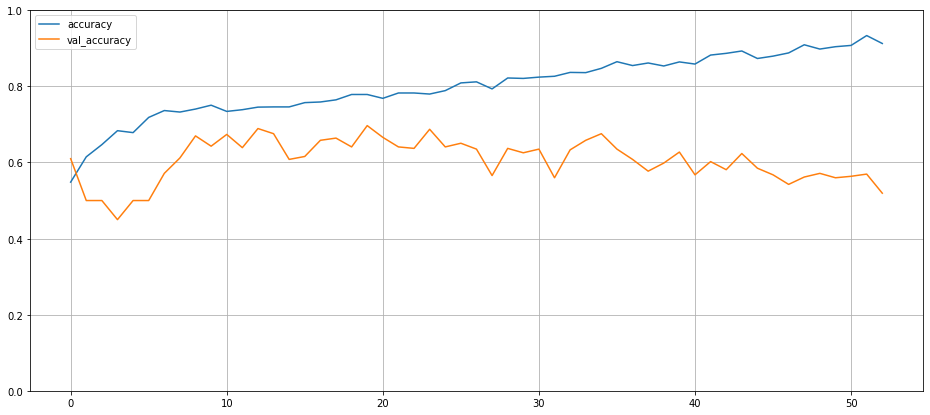

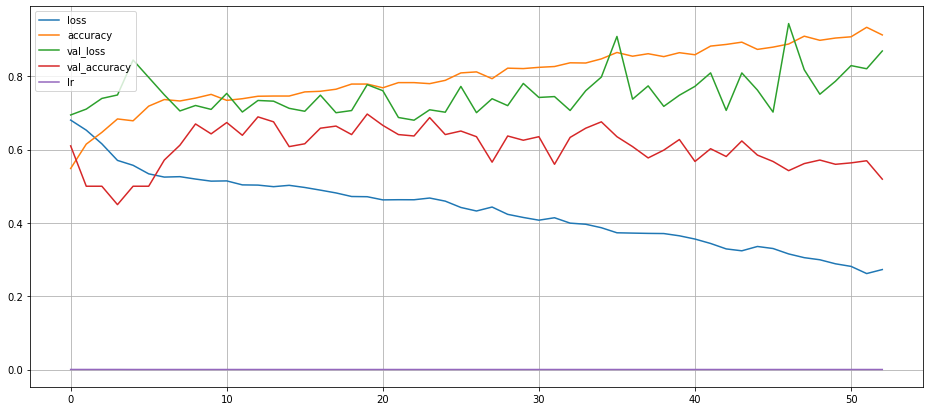

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

dF = pd.DataFrame(CNNmodel.history)
print(dF.head())

dF[["val_loss"]].plot(xlabel="Epoch Number",ylabel="Validation Loss",title="Validation Loss against Epoch Number")
plt.legend().remove()
plt.grid()

dF[["loss","val_loss"]].plot(figsize=(16,7))
plt.grid()

dF[["accuracy","val_accuracy"]].plot(figsize=(16,7))
plt.grid()
plt.ylim([0,1])

dF.plot(figsize=(16,7))
plt.grid()